# Capstone Final Project – The Battle of Neighborhoods 
## (Finding a Better Place in North York, Toronto)


### 1. Installing and Importing Python Libraries and Dependencies

In [1]:
!pip install geocoder
!pip install folium

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


### 2. Data Extraction and Cleaning

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(url)
soup = BeautifulSoup(page.text, "lxml")

table = soup.find_all('table')

df = pd.read_html(str(table))[0]

df.head()

,0,1,2,3,4,5,6,7,8
0,M1ANot assigned,M2ANot assigned,M3ANorth York(Parkwoods),M4ANorth York(Victoria Village),M5ADowntown Toronto(Regent Park / Harbourfront),M6ANorth York(Lawrence Manor / Lawrence Heights),M7AQueen's Park(Ontario Provincial Government),M8ANot assigned,M9AEtobicoke(Islington Avenue)
1,M1BScarborough(Malvern / Rouge),M2BNot assigned,M3BNorth York(Don Mills)North,M4BEast York(Parkview Hill / Woodbine Gardens),"M5BDowntown Toronto(Garden District, Ryerson)",M6BNorth York(Glencairn),M7BNot assigned,M8BNot assigned,M9BEtobicoke(West Deane Park / Princess Garden...
2,M1CScarborough(Rouge Hill / Port Union / Highl...,M2CNot assigned,M3CNorth York(Don Mills)South(Flemingdon Park),M4CEast York(Woodbine Heights),M5CDowntown Toronto(St. James Town),M6CYork(Humewood-Cedarvale),M7CNot assigned,M8CNot assigned,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...
3,M1EScarborough(Guildwood / Morningside / West ...,M2ENot assigned,M3ENot assigned,M4EEast Toronto(The Beaches),M5EDowntown Toronto(Berczy Park),M6EYork(Caledonia-Fairbanks),M7ENot assigned,M8ENot assigned,M9ENot assigned
4,M1GScarborough(Woburn),M2GNot assigned,M3GNot assigned,M4GEast York(Leaside),M5GDowntown Toronto(Central Bay Street),M6GDowntown Toronto(Christie),M7GNot assigned,M8GNot assigned,M9GNot assigned


In [4]:
#Wrangling the DataFrame
flatten_array = df.values.flatten()

#Rearranging the text
clean_list = []
for i in range(len(flatten_array)):
  temp_list = []
  postal_code = flatten_array[i][:3]
  temp_list.append(postal_code)
  borough_neighbor = flatten_array[i][3:].split('(')
  if len(borough_neighbor) > 1:
    borough = borough_neighbor[0]
    temp_list.append(borough)
    neighbor = borough_neighbor[1].split(')')
    neighbor = neighbor[0].replace(' / ',', ')
    temp_list.append(neighbor)
  else:
    borough = borough_neighbor[0]
    temp_list.append(borough)
  clean_list.append(temp_list)

df_list = []
for i in range(len(clean_list)):
  if clean_list[i][1] == 'Not assigned':
    None
  else:
    df_list.append(clean_list[i])
#Create new Dataframe
df_toronto = pd.DataFrame(df_list)
df_toronto.columns = ['PostalCode','Borough','Neighborhood']
df_toronto.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [5]:
# Sorting
# set index for only Downtown Toronto
df = df_toronto[df_toronto['Borough'] == 'North York'].reset_index(drop=True)

In [6]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M6A,North York,"Lawrence Manor, Lawrence Heights"
3,M3B,North York,Don Mills
4,M6B,North York,Glencairn


In [7]:
df.describe()

,PostalCode,Borough,Neighborhood
count,24,24,24
unique,24,1,19
top,M2R,North York,Downsview
freq,1,24,4


In [8]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['PostalCode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [9]:
df_2.describe()

,PostalCode,Borough,Neighborhood
count,24,24,24
unique,24,1,19
top,M2R,North York,Downsview
freq,1,24,4


In [10]:
print(df_2.shape)
df_2.head()

(24, 3)


,PostalCode,Borough,Neighborhood
0,M2H,North York,Hillcrest Village
1,M2J,North York,"Fairview, Henry Farm, Oriole"
2,M2K,North York,Bayview Village
3,M2L,North York,"York Mills, Silver Hills"
4,M2M,North York,"Willowdale, Newtonbrook"


In [11]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.709020000000066, -79.36348999999996]

In [12]:
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['PostalCode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [13]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [14]:
df_2[df_2.PostalCode == 'M2K']

,PostalCode,Borough,Neighborhood,Latitude,Longitude
2,M2K,North York,Bayview Village,43.78112,-79.3806


In [15]:
df_2.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M2H,North York,Hillcrest Village,43.80225,-79.35558
1,M2J,North York,"Fairview, Henry Farm, Oriole",43.78097,-79.34781
2,M2K,North York,Bayview Village,43.78112,-79.38060
3,M2L,North York,"York Mills, Silver Hills",43.75698,-79.38060
4,M2M,North York,"Willowdale, Newtonbrook",43.79182,-79.41372
5,M2N,North York,Willowdale,43.76774,-79.40728
6,M2P,North York,York Mills West,43.74778,-79.40033
7,M2R,North York,Willowdale,43.77989,-79.44678
8,M3A,North York,Parkwoods,43.75245,-79.32991
9,M3B,North York,Don Mills,43.74923,-79.36186


In [16]:
address = 'North York,Toronto'

geolocator = Nominatim(user_agent="smy-application")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Seattle,Washington are 43.7543263, -79.44911696639593.


### 3. Map of North York

In [17]:
map_NorthYork = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NorthYork)  
    
map_NorthYork

In [18]:
address = 'North York,Toronto'

geolocator = Nominatim(user_agent="smy-application")
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.7543263, -79.44911696639593.


In [19]:
# @hiddel_cell
CLIENT_ID = 'VCIZSDUMCM4KEPC4XHWKYMCNDFZODBZ1FAVMSBKN2H0CACFS' # my Foursquare ID
CLIENT_SECRET = 'SWZZ3XL2RLJD4LCBZBXAJR2TDQHR1XKUQQKGB2FSVU1IEZ2W' # my Foursquare Secret
VERSION = '20210503'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: VCIZSDUMCM4KEPC4XHWKYMCNDFZODBZ1FAVMSBKN2H0CACFS
CLIENT_SECRET: SWZZ3XL2RLJD4LCBZBXAJR2TDQHR1XKUQQKGB2FSVU1IEZ2W


In [20]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [21]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc',
       'venue.location.neighborhood', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups'],
      dtype='object')

In [22]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### 4. Nearby Venues/Locations

In [23]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Grill Gate,"[{'id': '4bf58dd8d48988d1c0941735', 'name': 'M...",43.753123,-79.451690
1,Wolfie's Deli,"[{'id': '4bf58dd8d48988d146941735', 'name': 'D...",43.754875,-79.442438
2,Tim Hortons,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.754767,-79.443250
3,Orly Restaurant & Grill,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",43.754493,-79.443507
4,Bagel Plus,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",43.755395,-79.440686


### 5. Categories of Nearby Venues/Locations

In [24]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Grill Gate,Mediterranean Restaurant,43.753123,-79.451690
1,Wolfie's Deli,Deli / Bodega,43.754875,-79.442438
2,Tim Hortons,Coffee Shop,43.754767,-79.443250
3,Orly Restaurant & Grill,Middle Eastern Restaurant,43.754493,-79.443507
4,Bagel Plus,Restaurant,43.755395,-79.440686


In [25]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Pizza Place                  3
Restaurant                   1
Fried Chicken Joint          1
Mediterranean Restaurant     1
Sushi Restaurant             1
Grocery Store                1
Deli / Bodega                1
Coffee Shop                  1
American Restaurant          1
Middle Eastern Restaurant    1
Name: categories, dtype: int64

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
# Nearby Venues
NorthYork_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale
York Mills West
Willowdale
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Bedford Park, Lawrence Manor East
Lawrence Manor, Lawrence Heights
Glencairn
North Park, Maple Leaf Park, Upwood Park
Humber Summit
Humberlea, Emery


In [28]:
print('There are {} Uniques Categories.'.format(len(NorthYork_venues['Venue Category'].unique())))
NorthYork_venues.groupby('Neighborhood').count().head()

There are 126 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Bathurst Manor, Wilson Heights, Downsview North",16,16,16,16,16,16
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",27,27,27,27,27,27
Don Mills,50,50,50,50,50,50
Downsview,66,66,66,66,66,66


### 6. One Hot Encoding of Features

In [29]:
# one hot encoding
NorthYork_onehot = pd.get_dummies(NorthYork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NorthYork_onehot['Neighborhood'] = NorthYork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [NorthYork_onehot.columns[-1]] + list(NorthYork_onehot.columns[:-1])
NorthYork_onehot = NorthYork_onehot[fixed_columns]
NorthYork_grouped = NorthYork_onehot.groupby('Neighborhood').mean().reset_index()
NorthYork_onehot.head(5)

,Neighborhood,African Restaurant,Airport,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Store,Big Box Store,Bike Shop,Bookstore,Boutique,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Electronics Store,Falafel Restaurant,Fast Food Restaurant,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hotel,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Leather Goods Store,Liquor Store,Lounge,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Music Store,Nightclub,Optical Shop,Park,Pet Store,Pharmacy,Pizza Place,Platform,Plaza,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,Salon / Barbershop,Sandwich Place,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Smoothie Shop,Soccer Field,Social Club,Spa,Sporting Goods Shop,Sports Club,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Toy / Game Store,Trail,Turkish Restaurant,Video Game Store,Vietnamese Restaurant,Wings Joint,Women's Store,Yoga Studio
0,Hillcrest Village,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Hillcrest Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Hillcrest Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Hillcrest Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Hillcrest Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
num_top_venues = 5
for hood in NorthYork_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =NorthYork_grouped[NorthYork_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Bathurst Manor, Wilson Heights, Downsview North ----
                       venue  freq
0                Pizza Place  0.12
1                       Park  0.12
2                Coffee Shop  0.12
3              Deli / Bodega  0.06
4  Middle Eastern Restaurant  0.06


---- Bayview Village ----
              venue  freq
0       Gas Station  0.25
1  Asian Restaurant  0.25
2              Park  0.25
3             Trail  0.25
4          Pharmacy  0.00


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0  Italian Restaurant  0.07
1      Sandwich Place  0.07
2         Coffee Shop  0.07
3          Restaurant  0.07
4         Pizza Place  0.07


---- Don Mills ----
                 venue  freq
0          Coffee Shop  0.10
1           Restaurant  0.06
2                  Gym  0.04
3  Sporting Goods Shop  0.04
4          Supermarket  0.04


---- Downsview ----
                   venue  freq
0            Coffee Shop  0.09
1  Vietnamese Restaurant  0.06
2          Grocery Stor

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### 7.  Most Common Venues Near Neighborhood

In [32]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NorthYork_grouped['Neighborhood']

for ind in np.arange(NorthYork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NorthYork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bathurst Manor, Wilson Heights, Downsview North",Pizza Place,Park,Coffee Shop,Mobile Phone Shop,Sandwich Place,Restaurant,Fried Chicken Joint,Sushi Restaurant,Middle Eastern Restaurant,Intersection
1,Bayview Village,Park,Asian Restaurant,Trail,Gas Station,Yoga Studio,Discount Store,Food & Drink Shop,Fast Food Restaurant,Falafel Restaurant,Electronics Store
2,"Bedford Park, Lawrence Manor East",Restaurant,Coffee Shop,Italian Restaurant,Pizza Place,Sandwich Place,Butcher,Pub,Café,Pharmacy,Grocery Store
3,Don Mills,Coffee Shop,Restaurant,Supermarket,Italian Restaurant,Japanese Restaurant,Sporting Goods Shop,Bank,Gym,Dim Sum Restaurant,Movie Theater
4,Downsview,Coffee Shop,Vietnamese Restaurant,Grocery Store,Pizza Place,Discount Store,Fast Food Restaurant,Hotel,Park,Beer Store,Pharmacy


### 8. K-Means Clustering Approach

In [33]:
# Using K-Means to cluster neighborhood into 3 clusters
NorthYork_grouped_clustering = NorthYork_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(NorthYork_grouped_clustering)
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 2, 1, 2, 2, 2, 2, 1],
      dtype=int32)

In [34]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

NorthYork_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
NorthYork_merged = NorthYork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

NorthYork_merged.head()    # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M2H,North York,Hillcrest Village,43.80225,-79.35558,1,Park,Bakery,Chinese Restaurant,Fast Food Restaurant,Residential Building (Apartment / Condo),Pharmacy,Department Store,Deli / Bodega,Food & Drink Shop,Dessert Shop
1,M2J,North York,"Fairview, Henry Farm, Oriole",43.78097,-79.34781,2,Clothing Store,Coffee Shop,Fast Food Restaurant,Convenience Store,Restaurant,Women's Store,Toy / Game Store,Electronics Store,Baseball Field,Juice Bar
2,M2K,North York,Bayview Village,43.78112,-79.38060,2,Park,Asian Restaurant,Trail,Gas Station,Yoga Studio,Discount Store,Food & Drink Shop,Fast Food Restaurant,Falafel Restaurant,Electronics Store
3,M2L,North York,"York Mills, Silver Hills",43.75698,-79.38060,1,Concert Hall,Park,Food Truck,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
4,M2M,North York,"Willowdale, Newtonbrook",43.79182,-79.41372,2,Korean Restaurant,Middle Eastern Restaurant,Coffee Shop,Café,Pizza Place,Ice Cream Shop,Shopping Mall,Grocery Store,Hookah Bar,Greek Restaurant


### 9. Map of Clusters

In [35]:
kclusters = 10

In [36]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(NorthYork_merged['Latitude'], 
                                   NorthYork_merged['Longitude'], 
                                   NorthYork_merged['Neighborhood'], 
                                   NorthYork_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


### 10. House Rating by Clusters

In [37]:
df1=NorthYork_merged.loc[NorthYork_merged['Cluster Labels'] == 0,NorthYork_merged.columns[[2] + list(range(5, NorthYork_merged.shape[1]))]]
df2=NorthYork_merged.loc[NorthYork_merged['Cluster Labels'] == 1,NorthYork_merged.columns[[2] + list(range(5, NorthYork_merged.shape[1]))]]
df3=NorthYork_merged.loc[NorthYork_merged['Cluster Labels'] == 2,NorthYork_merged.columns[[2] + list(range(5, NorthYork_merged.shape[1]))]]

In [38]:
NorthYork_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0
                                                              
                                                              
                                                              ]})

In [39]:
NorthYork_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

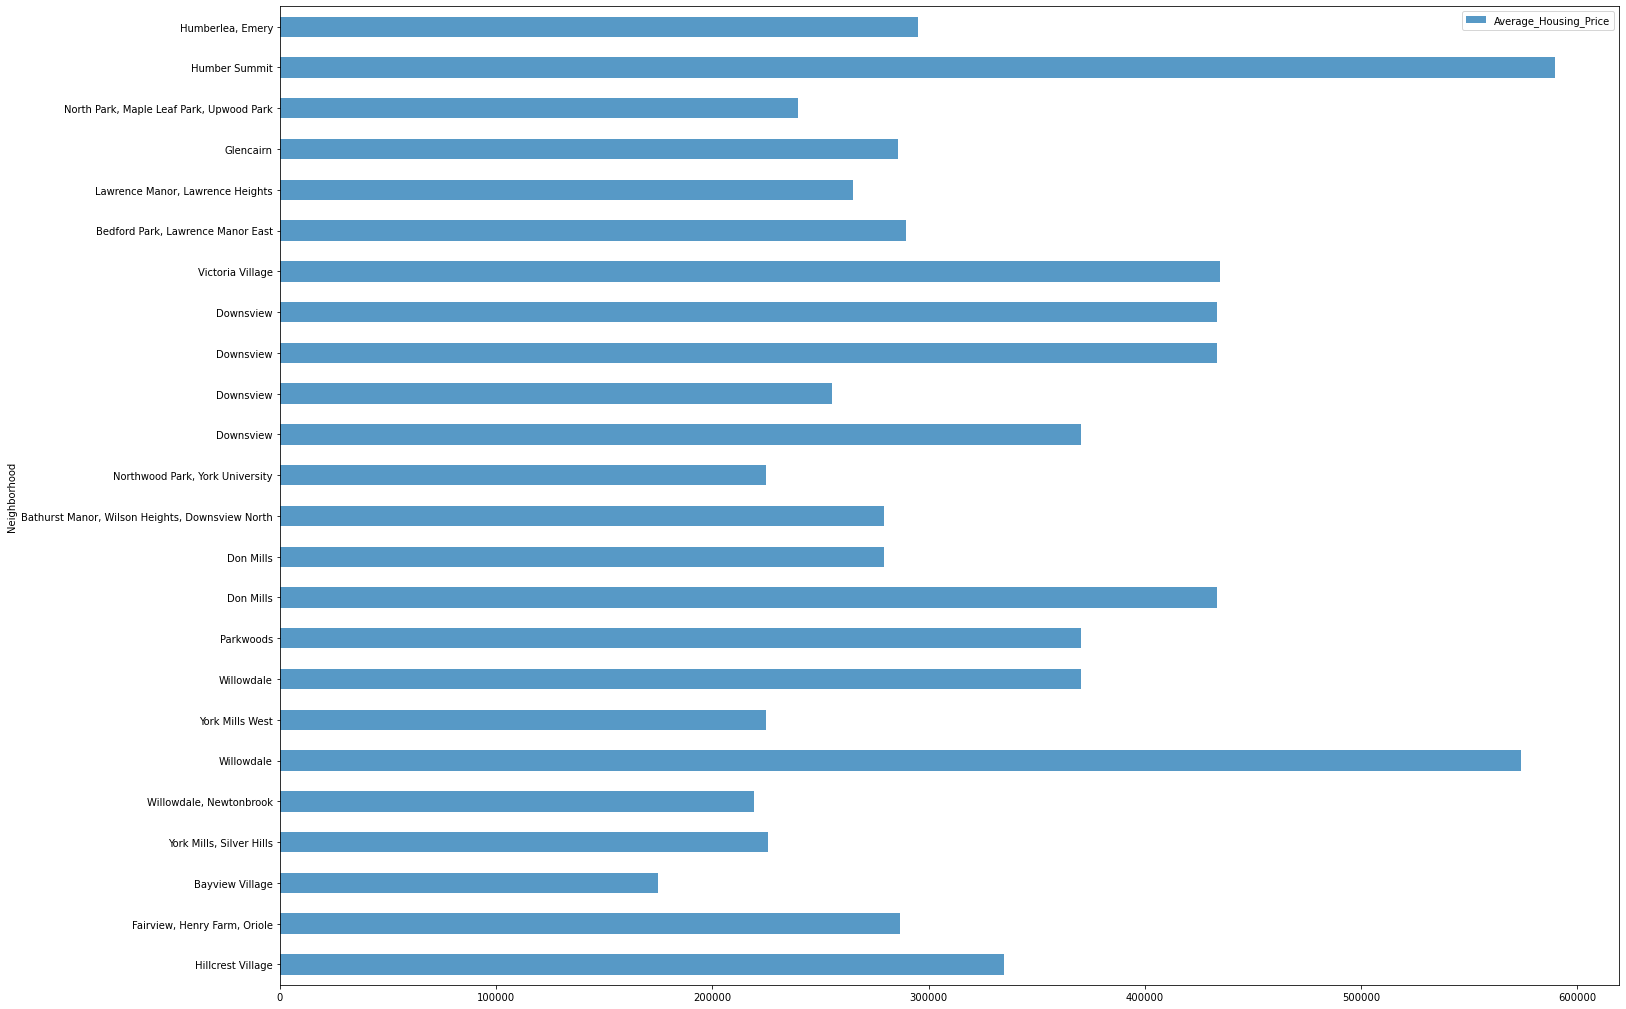

In [44]:
NorthYork_Avg_HousingPrice.plot(kind='barh',figsize=(24,18),alpha=0.75)


### 11. School Rating by Clusters

In [40]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [41]:
new_NorthYork=NorthYork_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
NorthYork_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,7,10,1,4,1,5,7,2,3,2,6,
                                                           5,4,8,9,9,6,8,7
                                                             ]})


In [42]:
NorthYork_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

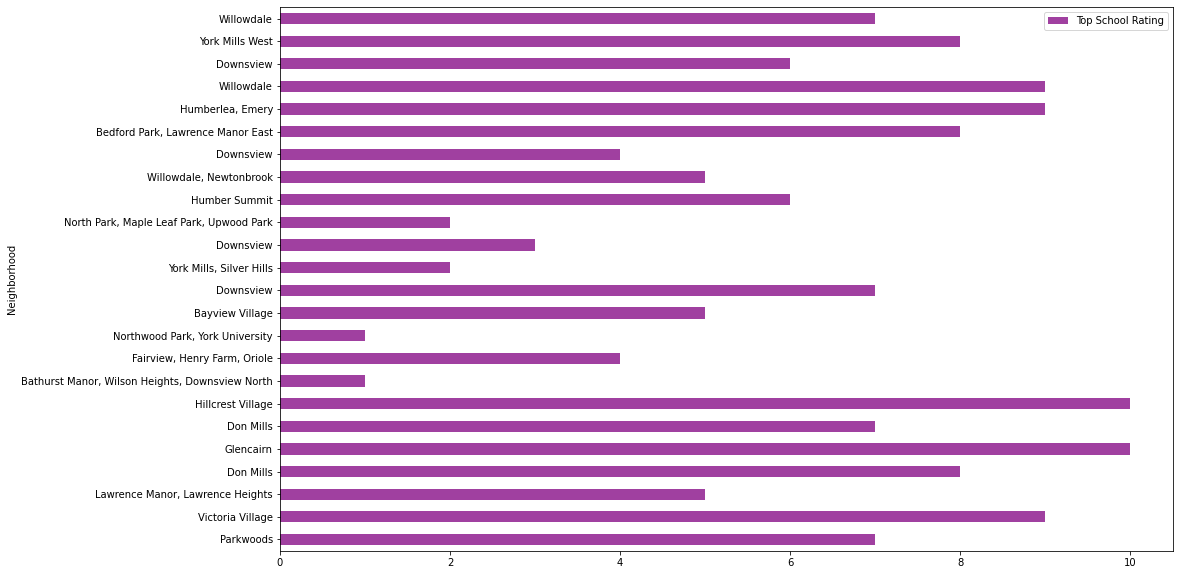

In [43]:
NorthYork_school_ratings.plot(kind='barh',figsize=(16,10),color='purple',alpha=0.75);


#### Conclusion:
In this project, using k-means cluster algorithm I separated the neighborhood into 10(Ten) different clusters and for 24 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.